In [1]:
import numpy as np
import pandas as pd
import string

In [2]:
data = pd.read_csv('../nlp-getting-started/train.csv',sep=',')
#df = data[['Phrase','Sentiment']]
df = data
print(df.head(10))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1  


<AxesSubplot:xlabel='target'>

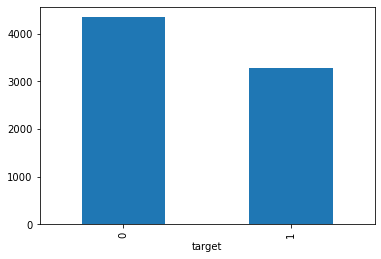

In [3]:
df.groupby(['target']).size().plot.bar()

In [4]:
import torch
import torch.utils.data
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-medium')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [label for label in df['target']]
        self.texts = [tokenizer(text, padding='max_length',
            max_length=512, truncation=True, return_tensors="pt")
            for text in df['text']]
    
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [5]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('prajjwal1/bert-medium')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer 

In [6]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, data, learning_rate, epochs):

    train_data, val_data = np.split(data.sample(frac=1), [int(.99*len(data))])
    print(len(train_data), len(val_data))
    train, val = Dataset(train_data), Dataset(val_data)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} '\
            f'| Train Accuracy: {total_acc_train / len(train_data): .3f} '\
            f'| Val Loss: {total_loss_val / len(val_data): .3f} '\
            f'| Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 3
model = BertClassifier()
LR = 1e-5

train(model, df, LR, EPOCHS)

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7536 77


100%|██████████| 3768/3768 [03:49<00:00, 16.39it/s]


Epochs: 1 | Train Loss:  0.218 | Train Accuracy:  0.807 | Val Loss:  0.188 | Val Accuracy:  0.792


100%|██████████| 3768/3768 [03:50<00:00, 16.32it/s]


Epochs: 2 | Train Loss:  0.151 | Train Accuracy:  0.883 | Val Loss:  0.195 | Val Accuracy:  0.818


100%|██████████| 3768/3768 [03:54<00:00, 16.06it/s]


Epochs: 3 | Train Loss:  0.093 | Train Accuracy:  0.934 | Val Loss:  0.198 | Val Accuracy:  0.870


In [7]:
torch.save(model.state_dict(), "bert-medium-movie-review.model")

In [8]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-medium')

model = BertClassifier()
model.load_state_dict(torch.load("bert-medium-movie-review.model"))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    model = model.cuda()

test_text = "I think this movie is great"
with torch.no_grad():
    test_input = tokenizer(test_text, padding='max_length',
        max_length=512, truncation=True, return_tensors="pt")
    mask = test_input['attention_mask'].to(device)
    input_id = test_input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)
    label = output.argmax(dim=1).item()
    print("Label:", label)

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Label: 0


In [9]:
df = pd.read_csv('../nlp-getting-started/test.csv',sep=',')
df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
answer = pd.DataFrame(columns=['id', 'target'])
for index, row in df.iterrows():
    with torch.no_grad():
        test_text = row['text']
        test_input = tokenizer(test_text, padding='max_length',
            max_length=512, truncation=True, return_tensors="pt")
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)
        label = output.argmax(dim=1).item()
        answer_row = {'id': row['id'], 'target': label}
        answer = answer.append(answer_row, ignore_index=True)
        #print(row['PhraseId'], ' ' * 5, end='\r')
answer.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16212\3503100192.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(answer_row, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16212\3503100192.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(answer_row, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16212\3503100192.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  answer = answer.append(answer_row, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16212\3503100192.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [11]:
answer.to_csv("submission_bert_medium3.csv", index=False)